In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import ngrams
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer 
from sklearn import metrics

import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import ngrams
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
import re
from bs4 import BeautifulSoup
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup


Using TensorFlow backend.


In [3]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\armug\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tweets = pd.read_csv('sentimeqnt_tweets3.csv')
tweets.head(20)

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [6]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [7]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

# Splitting the Data in Training and Testing Sets
As you can see, I used almost all the data for training: 98% and the rest for testing.

In [8]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [9]:
trainData.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


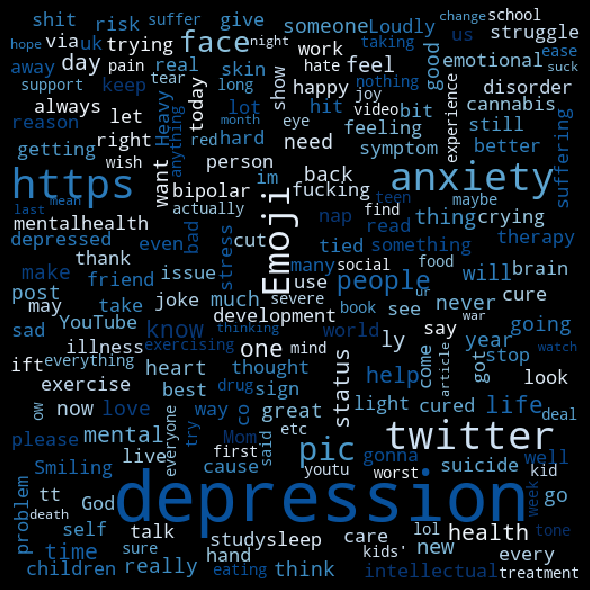

In [10]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

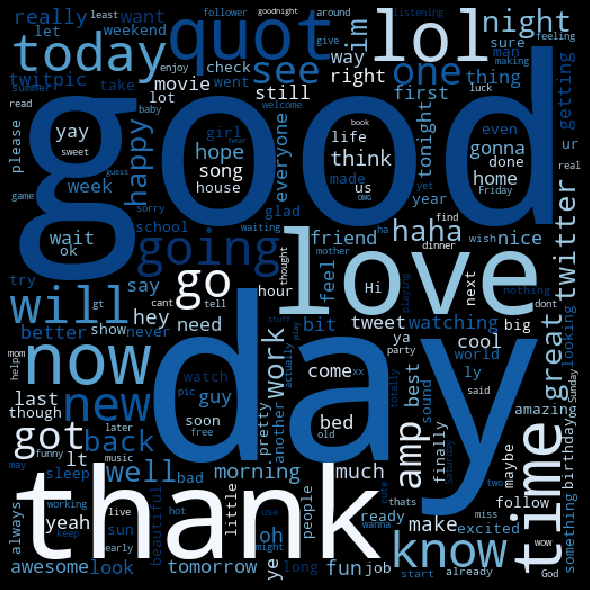

In [11]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [15]:
tweets.columns = ['Text', 'Sentiment']

In [17]:
tweets['Depression'] = 'True'
tweets.loc[tweets['Sentiment'] ==0,'Depression'] = 'False'

In [20]:
tweets

,Text,Sentiment,Depression
0,just had a real good moment. i missssssssss hi...,0,False
1,is reading manga http://plurk.com/p/mzp1e,0,False
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,False
3,@lapcat Need to send 'em to my accountant tomo...,0,False
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,False
5,so sleepy. good times tonight though,0,False
6,"@SilkCharm re: #nbn as someone already said, d...",0,False
7,23 or 24ï¿½C possible today. Nice,0,False
8,nite twitterville workout in the am -ciao,0,False
9,"@daNanner Night, darlin'! Sweet dreams to you",0,False


In [21]:
result_df = tweets.copy()

In [22]:
result_df.dtypes

Text          object
Sentiment      int64
Depression    object
dtype: object

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text=str(text)
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
#    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [24]:
result_df['Text'] = result_df['Text'].apply(clean_text)

In [25]:
result_df=result_df.drop_duplicates()
result_df=result_df.dropna()

In [26]:
df1=result_df.copy()

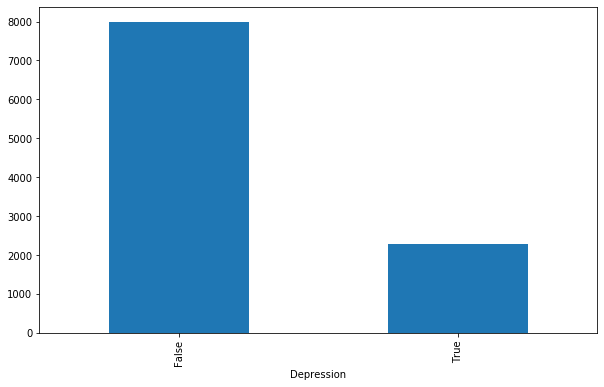

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
df1.groupby('Depression').Text.count().plot.bar(ylim=0)
plt.show()


In [28]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [29]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 23601 unique tokens.


In [30]:
X = tokenizer.texts_to_sequences(df1['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10266, 250)


In [31]:
Y = pd.get_dummies(df1['Depression']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10266, 2)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9239, 250) (9239, 2)
(1027, 250) (1027, 2)


In [33]:
import os

# LSTM and Word Embedding

In [34]:
t = Tokenizer()
t.fit_on_texts(df1['Text'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(df1['Text'])
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 500
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[21, 80, 4, 201, 27, 674, 1, 6711, 189, 20, 84], [10, 497, 6712, 26, 540, 283, 6713], [3328, 26, 170, 6714, 26, 1370, 6715], [6716, 109, 2, 573, 851, 2, 8, 6717, 138, 6718, 1, 486, 150, 2037, 2, 8, 6719, 205, 28, 1641, 1277, 195], [425, 17, 15, 700, 6720, 6721], [20, 1278, 27, 324, 185, 195], [6722, 1049, 6723, 64, 172, 250, 274, 247, 6724, 2, 3, 130, 349, 54, 51, 37, 32, 314, 22, 1371, 41], [1182, 61, 6725, 1183, 62, 129], [701, 3329, 1279, 13, 3, 73, 6726], [6727, 85, 6728, 336, 852, 2, 6], [27, 105, 727], [237, 1, 21, 1372, 8, 2732, 350, 371, 250, 4, 350, 38, 15, 3, 1511, 404, 1814, 26, 474, 6729], [6730, 93, 2733, 39, 133, 58, 823, 93, 39, 33, 4348, 702, 58, 21, 405, 211, 15, 574], [3330, 166, 1, 405, 14, 659, 12, 30, 148, 51, 6, 162, 637], [1, 82, 36, 6731, 5, 2734], [6732, 2339, 24, 4349, 1, 35, 4349, 4350, 51, 216, 12, 33], [6733, 63, 2340, 1, 2735, 233, 231, 157, 8, 350, 26, 6734, 98, 19, 2, 39, 4, 415, 2, 23, 659, 15, 2038], [6735, 6736, 2736, 91], [265, 126, 2737, 38, 2, 444

In [35]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, '')


# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open('glove.6B.300d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

Indexing word vectors.


In [36]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
len(embedding_matrix)

23602

In [38]:
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=250, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.05,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])


Train on 8777 samples, validate on 462 samples
Epoch 1/20
8777/8777 [==============================] - 59s 7ms/step - loss: 0.1279 - accuracy: 0.9565 - val_loss: 0.0134 - val_accuracy: 0.9978
Epoch 2/20
8777/8777 [==============================] - 63s 7ms/step - loss: 0.0252 - accuracy: 0.9953 - val_loss: 0.0128 - val_accuracy: 0.9978
Epoch 3/20
8777/8777 [==============================] - 65s 7ms/step - loss: 0.0249 - accuracy: 0.9949 - val_loss: 0.0141 - val_accuracy: 0.9978
Epoch 4/20
8777/8777 [==============================] - 66s 8ms/step - loss: 0.0231 - accuracy: 0.9954 - val_loss: 0.0137 - val_accuracy: 0.9978


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1027/1027 [==============================] - 2s 2ms/step
Test set
  Loss: 0.036
  Accuracy: 0.992


##### Saving Model

In [40]:
from keras.models import load_model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


##### Loading Model

In [41]:
model1 = load_model('model.h5')
# summarize model.
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          7080600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 7,241,202
Trainable params: 160,602
Non-trainable params: 7,080,600
_________________________________________________________________


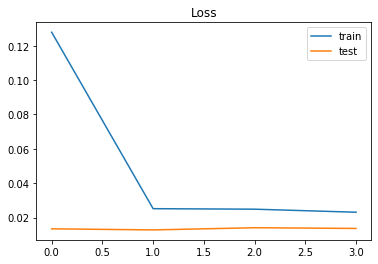

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

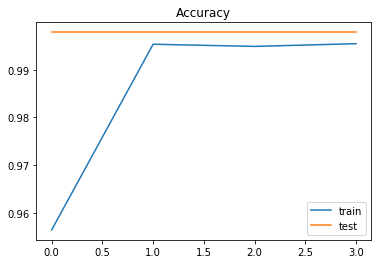

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [46]:
y_pred=model1.predict(X_test)
Y_test
list_pred=[]
for pred in y_pred:
    mval=0
    gval=0
    i=0
    for val in pred:
        if(val>gval):
            mval=i
            gval=val
        i+=1
    list_pred.append(mval)
new_list=[]
j=0
m_zero=np.zeros((2, 1027))
for i in list_pred:
    m_zero[i][j]=1
    j+=1

In [47]:
len(y_pred)

1027

In [48]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [49]:
preds=indices_to_one_hot(list_pred,2)

In [50]:
preds=preds.astype(int)
Y1_test=Y_test.astype(int)

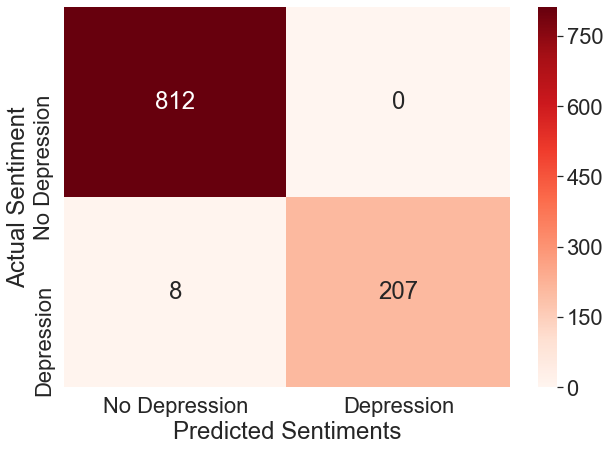

In [64]:
#printing the Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = ['No Depression','Depression']
cm = confusion_matrix(Y1_test.argmax(axis=1), preds.argmax(axis=1))
#print(cm)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(cm, annot=True,fmt='d',
            xticklabels=labels, yticklabels=labels,cmap='Reds')
sns.set(font_scale = 12)
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiments')
plt.show()

In [52]:

# Finding Precision,recall,and f1-score for Naive Bayes

print('Metrics Classification Report : LSTM')
print(metrics.classification_report(Y1_test, preds))

Metrics Classification Report : LSTM
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       812
           1       1.00      0.96      0.98       215

   micro avg       0.99      0.99      0.99      1027
   macro avg       1.00      0.98      0.99      1027
weighted avg       0.99      0.99      0.99      1027
 samples avg       0.99      0.99      0.99      1027



In [53]:
len(preds)

1027

# Predictions with TF-IDF and Bag of Words (BOW)

In [54]:
## Test with a new sentence.

new_sentence = ['Loving how me and my lovely partner is talking about what we want']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Loving how me and my lovely partner is talking about what we want'] No Depression


In [55]:
## Test with a new sentence.

new_sentence = ['Hi hello depression and anxiety are the worst']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Hi hello depression and anxiety are the worst'] Depression


In [56]:
## Test with a new sentence.

new_sentence = ['Extreme sadness, lack of energy, hopelessness']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Extreme sadness, lack of energy, hopelessness'] Depression


In [57]:
## Test with a new sentence.

new_sentence = ['My depression will not let me work out']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['My depression will not let me work out'] Depression


In [58]:
## Test with a new sentence.

new_sentence = ['Loving how me and my lovely partner is talking about what we want']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Loving how me and my lovely partner is talking about what we want'] No Depression


In [59]:
## Test with a new sentence.

new_sentence = ['Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits'] No Depression


In [60]:
## Test with a new sentence.

new_sentence = ['Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#print(pred[0].tolist())
labels = ['No Depression','Depression']
print(new_sentence, labels[np.argmax(pred)])

['Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy'] No Depression


# Predictions with TF-IDF and Bag of Words (BOW)

In [65]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [66]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [67]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [68]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.95
Recall:  0.38
F-score:  0.5428571428571428
Accuracy:  0.8375634517766497


In [69]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.9285714285714286
Recall:  0.26
F-score:  0.40625
Accuracy:  0.8071065989847716


## Depressive Tweets
### TF-IDF

In [70]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [71]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)


True

### Bag of words

In [74]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [75]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

True

## Positive Tweets
### TF-IDF

In [76]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)


False

In [77]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)


False

### Bag of words

In [78]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

False

In [79]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

False